In [1]:
import lsst.daf.persistence as dafPersist
import lsst.afw.image as afwImage
import lsst.afw.geom as afwGeom

import math

# We are going to analyse the following patches. We assume that these patches are
# all in the same tract (0)
patchList = ['3,4', '4,7']

# Initialize butler
butler = dafPersist.Butler("/home/boutigny/LSST/CFHT/SXDS/output/coadd_dir")

In [2]:
for i, patch in enumerate(patchList) :
    
    dataId_u = {'tract':0, 'filter':'u', 'patch':patch}

    meas_u = butler.get('deepCoadd_meas', dataId=dataId_u)
    md_u = butler.get('deepCoadd_calexp', dataId=dataId_u)
    calib_u = md_u.getCalib()

    if i == 0 :
        schema = meas_u.getSchema()

        # Get keys from the measurement catalog
        # The following is not strictly necessary as one could use the get("key_name") method to access values in the
        # catalogs, but it is much more efficient to use get(key)
        fluxKey = schema["modelfit_CModel_flux"].asKey()
        fluxSigmaKey = schema["modelfit_CModel_fluxSigma"].asKey()
        fluxFlagKey = schema["modelfit_CModel_flag"].asKey()
        extKey = schema["base_ClassificationExtendedness_value"].asKey()
        extFlagKey = schema["base_ClassificationExtendedness_flag"].asKey()
        raKey = schema["coord_ra"].asKey()
        decKey = schema["coord_dec"].asKey()
        
        # Initialize some lists
        mag_u = []
        sn_u = []
        raSrc = []
        decSrc = []
        starGal = []

    # Loop over deblended sources in the u deepCoadd_meas catalogs
    for i in range(len(meas_u)) :
        # Select galaxies (and reject stars)
        if meas_u[i].get(extFlagKey) :
            continue
        starGal.append(meas_u[i].get(extKey))
        
        # Select sources which have a proper flux value in r, g and i bands
        # Notice that it would not be strictly necessary with forced photometry
        if meas_u[i].get(fluxFlagKey) :
            continue
        flux_u = meas_u[i].get(fluxKey)
        if flux_u <= 0. :
            continue
        fluxS_u = meas_u[i].get(fluxSigmaKey)
        sn_u.append(flux_u / fluxS_u)

        # Need to use a calibobject in order to convert flux to magnitude
        mag_u.append(calib_u.getMagnitude(flux_u))

print "Number of sources: ", len(mag_u)

Number of sources:  21263


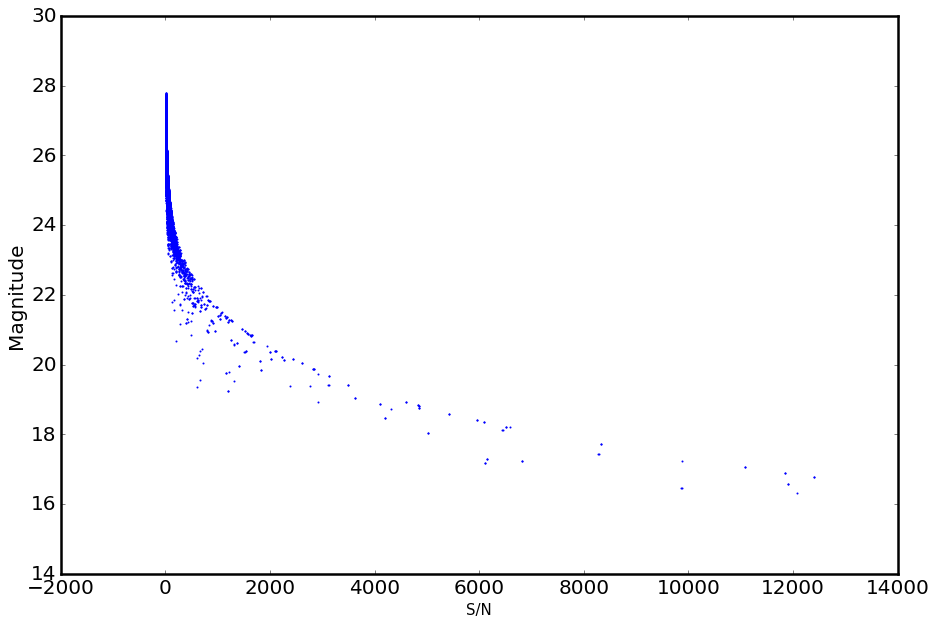

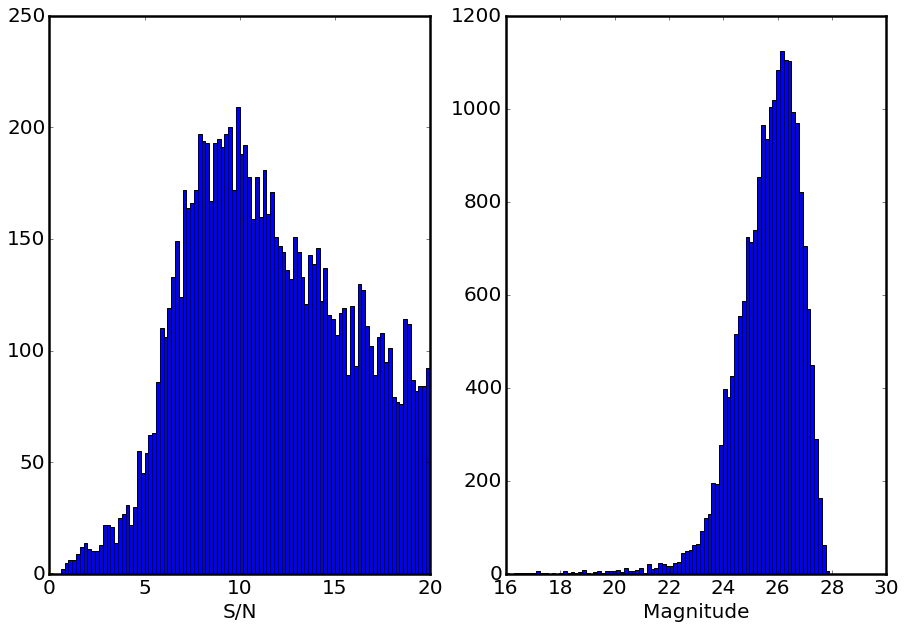

In [9]:
%matplotlib inline
import matplotlib
import matplotlib.pylab as plt
import numpy as np

font = {'family' : 'serif',
        'color'  : 'darkred',
        'weight' : 'bold',
        'size'   : 25,
        }

plt.rcParams['axes.linewidth'] = 2.5 #set the value globally

cutMag = np.asarray(mag_u) > 15
cutSN = np.asarray(sn_u) > 5

cutTot = cutMag & cutSN

fig, (ax1) = plt.subplots(ncols=1, figsize=(15, 10))
ax1.scatter(np.asarray(sn_u)[cutTot], np.asarray(mag_u)[cutTot], s=1, color='b')
ax1.tick_params(labelsize=20)
ax1.set_xlabel("S/N", fontsize=15)
ax1.set_ylabel("Magnitude", fontsize=20)

fig, (ax2, ax3) = plt.subplots(ncols=2, figsize=(15, 10))
ax2.hist(np.asarray(sn_u)[cutMag], bins=100, range = [0, 20])
ax3.hist(np.asarray(mag_u)[cutSN], bins=100, range = [16, 30])
ax2.tick_params(labelsize=20)
ax2.set_xlabel("S/N", fontsize=20)
ax3.tick_params(labelsize=20)
ax3.set_xlabel("Magnitude", fontsize=20)